In [1]:
# Setup imports and path so `src` package is importable
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import logging
# Reduce TensorFlow logging to suppress known deprecation warnings from TF and TFP
# Set C++ minimal log level (0=all,1=INFO,2=WARNING,3=ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Reduce Python-side TensorFlow logger verbosity
try:
    tf.get_logger().setLevel(logging.ERROR)
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    # Also set v1 logging verbosity if available
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception:
    pass

# ensure the project root is on sys.path so `src` is importable
# project_root = r"C:\Users\yecha\workspace\JPMSummer"
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

from src.data.data import SSMData, StochasticVariationalData
from src.models.KalmanFilter import KalmanFilter
from src.models.ExtendedKalmanFilter import ExtendedKalmanFilter
from src.models.UnscentedKalmanFilter import UnscentedKalmanFilter
from src.models.ParticleFilter import ParticleFilter

import tensorflow_probability as tfp
tfd = tfp.distributions

tf.random.set_seed(1)
np.random.seed(1)

## 1) Multidimensional linear Gaussian SSM and Kalman Filter

We construct a 2D constant-velocity system (state = [position, velocity]) and observe position and velocity with noise.

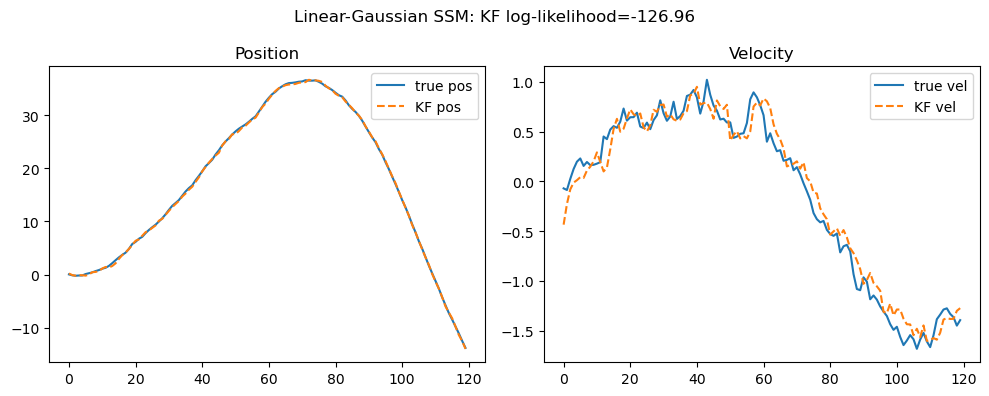

In [2]:
# Build a simple 2D constant-velocity model
dt = 1.0
A = np.array([[1.0, dt], [0.0, 1.0]], dtype=float)  # transition
H = np.eye(2, dtype=float)  # observe both states
Q = np.eye(2, dtype=float) * 0.01  # small process noise
R = np.eye(2, dtype=float) * 0.1   # observation noise

T = 120
initial_mean = np.zeros((2,))
initial_cov = np.eye(2) * 1.0

ssm = SSMData(
    transition_matrix=A,
    observation_matrix=H,
    transition_cov=Q,
    observation_cov=R,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dtype=tf.float64,
)

x_true_tf, y_tf = ssm.sample(num_steps=T, seed=42)
# Convert to numpy for plotting/feeding non-tf filters
x_true = x_true_tf.numpy()  # shape (T+1, state_dim)
y = y_tf.numpy()            # shape (T, obs_dim)

# Run Kalman Filter
kf = KalmanFilter(
    transition_matrix=A,
    observation_matrix=H,
    transition_cov=Q,
    observation_cov=R,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
)

filtered_means_tf, filtered_covs_tf, ll = kf.filter(tf.convert_to_tensor(y, dtype=tf.float64))
filtered_means = filtered_means_tf.numpy()

# Plot true vs filtered
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_true[1:, 0], label='true pos')
plt.plot(filtered_means[:, 0], '--', label='KF pos')
plt.title('Position')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_true[1:, 1], label='true vel')
plt.plot(filtered_means[:, 1], '--', label='KF vel')
plt.title('Velocity')
plt.legend()
plt.suptitle(f'Linear-Gaussian SSM: KF log-likelihood={float(ll):.2f}')
plt.tight_layout()
plt.show()

## 2) Generate stochastic variational dataset

We use the `StochasticVariationalData` class (1D) added to `data.py`.
Model (1D):
- X_k = alpha * X_{k-1} + sigma * eta_k  (eta_k ~ N(0,1))
- Y_k = beta * exp(X_k / 2) * epsilon_k (epsilon_k ~ N(0,1))

We'll simulate a series and visualize the latent log-volatility X and observations Y.

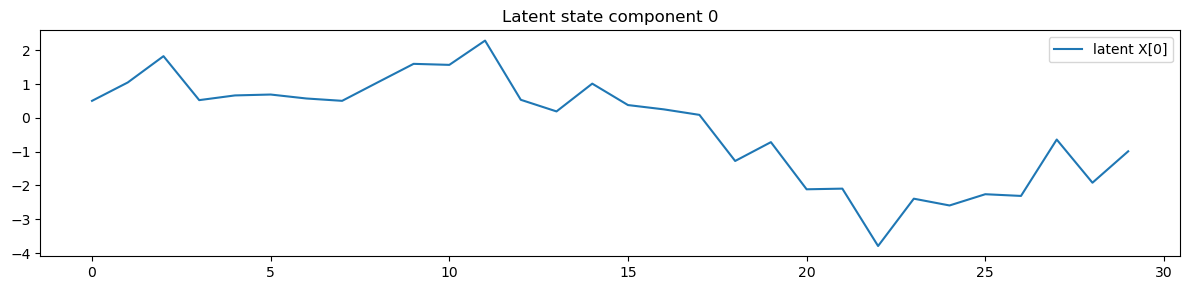

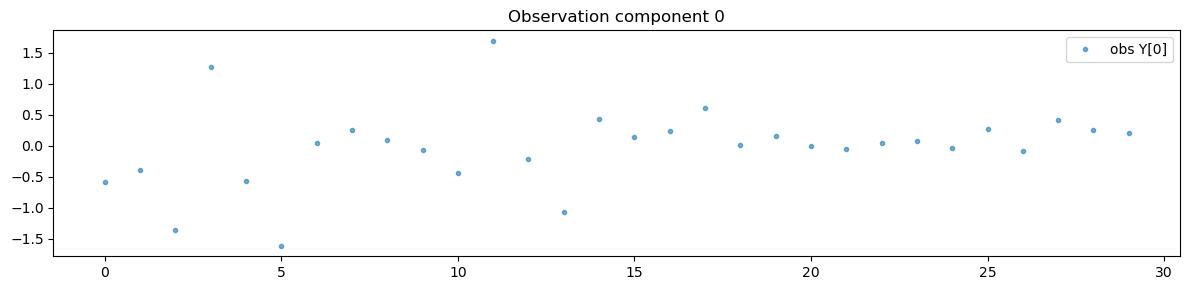

In [7]:
# Parameters for stochastic variational (stochastic volatility-like) model
alpha = 0.91
sigma = 1
beta = 0.5
T_sv = 30
n_state = 1
n_obs = 1
num_particles = 100
seed = 42

sv = StochasticVariationalData(alpha=alpha, 
                               sigma=sigma, 
                               beta=beta, 
                               n_state=n_state,
                               n_obs=n_obs,
                            #    initial_state=0.0, 
                               dtype=tf.float64)
x_sv_tf, y_sv_tf = sv.sample(num_steps=T_sv, seed=seed)
# x_sv: shape (T+1, n_state), y_sv: shape (T, n_obs)
x_sv = x_sv_tf.numpy()  # shape (T+1, n_state)
y_sv = y_sv_tf.numpy()  # shape (T, n_obs)

# Plot latent state components and observations (one subplot per state)
plt.figure(figsize=(12, 3 * max(1, n_state)))
for i in range(n_state):
    plt.subplot(n_state, 1, i + 1)
    plt.plot(x_sv[1:, i], label=f'latent X[{i}]')
    plt.title(f'Latent state component {i}')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3 * max(1, n_obs)))
for j in range(n_obs):
    plt.subplot(n_obs, 1, j + 1)
    plt.plot(y_sv[:, j], '.', alpha=0.6, label=f'obs Y[{j}]')
    plt.title(f'Observation component {j}')
    plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import tensorflow as tf


def f(x: tf.Tensor) -> tf.Tensor:
    # Support scalar or per-dimension `alpha` and both vector/batch inputs
    x = tf.cast(x, dtype=tf.float64)
    a = tf.cast(alpha, dtype=tf.float64)
    return a * x


def h(x: tf.Tensor) -> tf.Tensor:
    # Elementwise volatility transform: beta * exp(x/2).
    # Accepts vector (n_state,) or batch (N, n_state). If an observation
    # matrix `C` is present in the notebook namespace, map the per-state
    # contributions into observation space: y = C @ z.
    x = tf.cast(x, dtype=tf.float64)
    b = tf.cast(beta, dtype=tf.float64)
    z = b * tf.exp(x / 2.0)
    return z


# Approximate observation covariance R and process covariance Q for multivariate state
# Ensure beta and sigma are vectors of length n_state for per-dimension scaling
beta_vec = np.asarray(beta) if np.ndim(beta) > 0 else np.full((n_state,), float(beta))
sigma_vec = np.asarray(sigma) if np.ndim(sigma) > 0 else np.full((n_state,), float(sigma))
# # x_sv has shape (T+1, n_state); use time indices 1..T to compute empirical mean
# emp_R_diag = (beta_vec ** 2) * np.mean(np.exp(x_sv[1:, :]), axis=0)
# R_approx = np.diag(emp_R_diag).astype(float)
Q_approx = 0.5 * np.eye(n_state)
R_approx = 0.5 * np.eye(n_state)

# Initial conditions
initial_mean = np.zeros((n_state,))
initial_cov = np.eye(n_state)

print("Approximate R:", R_approx)
print("Approximate Q:", Q_approx)
print("initial_mean:", initial_mean)
print("initial_cov:", initial_cov)
# num_particles = 50

Approximate R: [[0.5]]
Approximate Q: [[0.5]]
initial_mean: [0.]
initial_cov: [[1.]]


## 3) Apply EKF & UKF to stochastic variational data (approximation)

We construct deterministic functions:
- f(x) = alpha * x  (transition mean)
- h(x) = beta * exp(x / 2)  (observation *scale* so actual observation is h(x) * epsilon)

Both EKF and UKF implementations assume additive observation noise y = h(x) + r with fixed covariance R. For this experiment we approximate the observation noise with a fixed scalar variance chosen as the empirical mean of beta^2 * exp(x). This is an approximation to make EKF/UKF run without changing their APIs. Particle filter (next) will use multiplicative noise naturally.

In [9]:
from src.models.PFPF import EDH_ParticleFlowPF, LEDH_ParticleFlowPF
from src.models.KernelFlow import KernelScalarFlow, KernelMatrixFlow
from src.models.EDH import EDH, LEDH

In [ ]:
verbose = True
# Create EKF and UKF instances
sv_ekf = ExtendedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

sv_ukf = UnscentedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

# PF for stochastic volatility
sv_pf = ParticleFilter(
    transition_fn=f,
    observation_fn=h,  # Original observation function for PF
    Q=Q_approx,
    R=R_approx,  # Original observation noise for PF
    num_particles=num_particles,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    seed=42,
)


# Prior particle cloud (Gaussian)
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(n_state, dtype=tf.float64), scale_diag=tf.ones(n_state, dtype=tf.float64))

particles_edh = prior.sample(num_particles)
particles_ledh = prior.sample(num_particles)

particles_edh_pfpf = prior.sample(num_particles)
particles_ledh_pfpf = prior.sample(num_particles)

particles_ks = prior.sample(num_particles)
particles_km = prior.sample(num_particles)


# Initialize EDH/LEDH filters with the sampled particles
sv_edh = EDH(num_particles,
            f = f,
            h = h,
            state_dim = n_state,
            observation_dim = n_obs,
            Q  = Q_approx,
            R = R_approx,
            dtype=tf.float64)
sv_edh.initialize(particles = particles_edh)

sv_ledh = LEDH(num_particles,
            f = f,
            h = h,
            state_dim = n_state,
            observation_dim = n_obs,
            Q  = Q_approx,
            R = R_approx,
            dtype=tf.float64)
sv_ledh.initialize(particles = particles_ledh)

pf_ledh = LEDH_ParticleFlowPF(num_particles, 
                                f=f, 
                                h=h, 
                                state_dim=n_state, 
                                observation_dim=n_obs, 
                                R=R_approx, 
                                Q=Q_approx, 
                                dtype=tf.float64)
pf_edh = EDH_ParticleFlowPF(num_particles, 
                            f=f, 
                            h=h, 
                            state_dim=n_state, 
                            observation_dim=n_obs, 
                            R=R_approx, 
                            Q=Q_approx, 
                            dtype=tf.float64)

pf_ledh.initialize(particles=particles_ledh_pfpf)
pf_edh.initialize(particles=particles_edh_pfpf)


ks = KernelScalarFlow(n_flow_steps=10)
km = KernelMatrixFlow(n_flow_steps=10)


sv_ledh.n_flow_steps = 10
sv_edh.n_flow_steps = 10
pf_ledh.n_flow_steps = 10
pf_edh.n_flow_steps = 10

# Run EKF and UKF on the observations
obs = tf.convert_to_tensor(y_sv.reshape(-1, 1), dtype=tf.float64)

# Ensure observation matrix matches stochastic-variational dims (1x1)
H_sv = np.eye(n_obs)

# Use R_approx (1x1) for the stochastic-variational experiment, not the earlier 2x2 `R`.
ks_means, ks_covs, ks_ll = ks.filter(obs.numpy(), particles_ks, h, R_approx, H_sv, verbose = verbose)
km_means, km_covs, km_ll = km.filter(obs.numpy(), particles_km, h, R_approx, H_sv, verbose = verbose)

edh_pfpf_means_tf, edh_pf_covs_tf, edh_pf_ll = pf_edh.filter(obs, verbose = verbose)
# ledh_pfpf_means_tf, ledh_pf_covs_tf, ledh_pf_ll = pf_ledh.filter(obs)
edh_means_tf, edh_covs_tf, edh_ll = sv_edh.filter(obs, verbose = verbose)
# ledh_means_tf, ledh_covs_tf, ledh_ll = sv_ledh.filter(obs)
pf_means_tf, pf_covs_tf, pf_ll = sv_pf.filter(obs)
ekf_means_tf, ekf_covs_tf, ekf_ll = sv_ekf.filter(obs)
ukf_means_tf, ukf_covs_tf, ukf_ll = sv_ukf.filter(obs)


sv_ks_means = ks_means.numpy().squeeze()
sv_km_means = km_means.numpy().squeeze()
sv_pf_means = pf_means_tf.numpy().squeeze()
sv_ekf_means = ekf_means_tf.numpy().squeeze()
sv_ukf_means = ukf_means_tf.numpy().squeeze()
sv_edh_means = edh_means_tf.numpy().squeeze()
# sv_ledh_means = ledh_means_tf.numpy().squeeze()
sv_edh_pfpf_means = edh_pfpf_means_tf.numpy().squeeze()
# sv_ledh_pfpf_means = ledh_pfpf_means_tf.numpy().squeeze()   



KernelScalarFlow.filter step=1 mean=[-0.042] loglik=-1.7571552712679002
KernelScalarFlow.filter step=2 mean=[-0.105] loglik=-1.3464773494668707
KernelScalarFlow.filter step=2 mean=[-0.105] loglik=-1.3464773494668707
KernelScalarFlow.filter step=3 mean=[-0.189] loglik=-3.80399893902791
KernelScalarFlow.filter step=3 mean=[-0.189] loglik=-3.80399893902791
KernelScalarFlow.filter step=4 mean=[-0.153] loglik=-1.193466997970976
KernelScalarFlow.filter step=4 mean=[-0.153] loglik=-1.193466997970976
KernelScalarFlow.filter step=5 mean=[-0.181] loglik=-1.6411439534225405
KernelScalarFlow.filter step=5 mean=[-0.181] loglik=-1.6411439534225405
KernelScalarFlow.filter step=6 mean=[-0.241] loglik=-4.789437927701217
KernelScalarFlow.filter step=6 mean=[-0.241] loglik=-4.789437927701217
KernelScalarFlow.filter step=7 mean=[-0.24] loglik=-0.7495367994944653
KernelScalarFlow.filter step=7 mean=[-0.24] loglik=-0.7495367994944653
KernelScalarFlow.filter step=8 mean=[-0.238] loglik=-0.6272646705933234
Ke

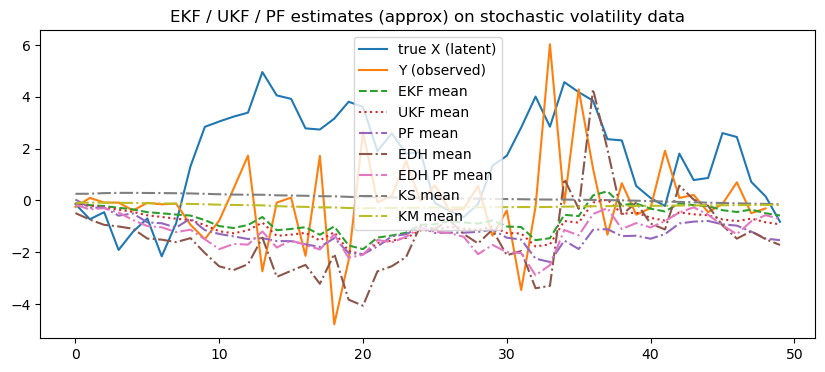

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(x_sv[1:], label='true X (latent)')
plt.plot(y_sv[1:], label='Y (observed)')
plt.plot(sv_ekf_means, '--', label='EKF mean')
plt.plot(sv_ukf_means, ':', label='UKF mean')
plt.plot(sv_pf_means, '-.', label='PF mean')
plt.plot(sv_edh_means, '-.', label='EDH mean')
# plt.plot(sv_ledh_means, '-.', label='LEDH mean')
plt.plot(sv_edh_pfpf_means, '-.', label='EDH PF mean')
# plt.plot(sv_ledh_pfpf_means, '-.', label='LEDH PF mean')
plt.plot(sv_ks_means, '-.', label='KS mean')
plt.plot(sv_km_means, '-.', label='KM mean')
plt.legend()
plt.title('EKF / UKF / PF estimates (approx) on stochastic volatility data')
plt.show()

## 4) Particle Filter on the stochastic variational data

The Particle Filter can directly handle multiplicative observation noise by using the deterministic observation function `h(x) = beta * exp(x/2)` and evaluating the likelihood p(y | x) = Normal(loc=0, scale=h(x)). We'll set a reasonably large number of particles for stability.

In [ ]:
# Initialize all filters
initial_mean = tf.constant([0.0], dtype=tf.float64)
initial_cov = tf.constant([[1.0]], dtype=tf.float64)
num_particles = 50

def f(x: tf.Tensor) -> tf.Tensor:
    return tf.cast(alpha, dtype=tf.float64) * x

def h(x: tf.Tensor) -> tf.Tensor:
    return tf.cast(beta, dtype=tf.float64) * tf.exp(x / 2.0)


# EKF for stochastic volatility
sv_ekf = ExtendedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

# UKF for stochastic volatility
sv_ukf = UnscentedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)


# PF for stochastic volatility
sv_pf = ParticleFilter(
    transition_fn=f,
    observation_fn=h,  # Original observation function for PF
    Q=Q_approx,
    R=R_approx,  # Original observation noise for PF
    num_particles=num_particles,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    seed=42,
)



# Run all filters
ekf_means, ekf_covs, ekf_ll = [], [], 0
ukf_means, ukf_covs, ukf_ll = [], [], 0
pf_means, pf_covs, pf_ll = [], [], 0
pf_esss = []  # track effective sample size (ESS) over time
edh_means, edh_covs, edh_ll = [], [], 0
ledh_means, ledh_covs, ledh_ll = [], [], 0

# Process returns
for t, y in enumerate(y_sv):

    # Run EKF and UKF on transformed observations
    ekf_mean, ekf_cov, ekf_loglik = sv_ekf.step(y)
    ukf_mean, ukf_cov, ukf_loglik = sv_ukf.step(y)
    
    # Run PF on original returns (can handle non-additive noise)
    pf_mean, pf_cov, pf_loglik = sv_pf.step(y)
    # Run EDH and LEDH on original returns
    edh_mean, edh_cov, edh_loglik = sv_edh.step(y)
    ledh_mean, ledh_cov, ledh_loglik = sv_ledh.step(y)


    
    # Store results
    ekf_means.append(ekf_mean.numpy())
    ekf_covs.append(ekf_cov.numpy())
    ekf_ll += float(ekf_loglik)
    
    ukf_means.append(ukf_mean.numpy())
    ukf_covs.append(ukf_cov.numpy())
    ukf_ll += float(ukf_loglik)
    
    pf_means.append(pf_mean.numpy())
    pf_covs.append(pf_cov.numpy())
    pf_ll += float(pf_loglik)
    # Record ESS (effective sample size) from the particle filter diagnostics
    try:
        pf_esss.append(float(sv_pf.last_ess.numpy()))
    except Exception:
        # Fallback if tensor->numpy not available
        pf_esss.append(float(sv_pf.last_ess))

# Convert to arrays
ekf_means = np.array(ekf_means).squeeze()
ukf_means = np.array(ukf_means).squeeze()
pf_means = np.array(pf_means).squeeze()

ekf_stds = np.sqrt([cov[0,0] for cov in ekf_covs])
ukf_stds = np.sqrt([cov[0,0] for cov in ukf_covs])
pf_stds = np.sqrt([cov[0,0] for cov in pf_covs])

AttributeError: 'EDH' object has no attribute 'step'

In [ ]:
import tensorflow as tf

# We'll create a custom PF instance but monkeypatch update to use multiplicative noise likelihood.
num_particles = 50

# Initialize PF with a tiny R (we will override likelihood computation below)
pf = ParticleFilter(
    transition_fn=f,
    observation_fn=h,
    Q=Q_approx,
    R=np.array([[1.0]]),  # placeholder
    num_particles=num_particles,
    initial_mean=tf.constant([0.0], dtype=tf.float64),
    initial_cov=tf.constant([[1.0]], dtype=tf.float64),
    seed=7,
)

# We'll run the PF step-by-step, but override the likelihood evaluation to use y ~ N(0, (beta*exp(x/2))^2)
est_means = []
est_covs = []
logliks = []

for t in range(T_sv):
    # Predict
    pf.predict()

    # Evaluate multiplicative-noise likelihood manually
    # particles: shape (N, state_dim) where state_dim==1
    particles = pf.particles  # tensor shape (N, 1)
    # Compute scale = beta * exp(x/2) per particle
    scales = tf.squeeze(tf.cast(beta, tf.float64) * tf.exp(particles[:, 0] / 2.0))  # shape (N,)

    # Compute particle-wise log-likelihood under N(0, scale^2)
    y_t = float(y_sv[t])
    pf.step(y_t)

    # compute log pdf: -0.5*log(2*pi*scale^2) - 0.5*(y^2/scale^2)
    log_likes = -0.5 * tf.math.log(2.0 * np.pi * (scales ** 2)) - 0.5 * (y_t ** 2) / (scales ** 2)

    # Update log weights using these log_likes
    new_log_w = pf.log_weights + tf.cast(log_likes, dtype=pf.dtype)
    log_norm_const = tf.reduce_logsumexp(new_log_w)
    normalized_log_w = new_log_w - log_norm_const
    pf.log_weights = normalized_log_w

    # ESS and resample as in ParticleFilter.update
    weights = tf.exp(pf.log_weights)
    ess = 1.0 / tf.reduce_sum(weights ** 2)
    pf.last_ess = ess
    try:
        pf.ess_history.append(float(ess.numpy()))
        pf.weights_history.append(weights.numpy())
    except Exception:
        pf.ess_history.append(float(ess))
        pf.weights_history.append(weights)

    threshold = tf.cast(pf.num_particles / 2.0, dtype=pf.dtype)
    if ess < threshold:
        idx = pf._systematic_resample(weights)
        pf.particles = tf.gather(pf.particles, idx)
        pf.log_weights = tf.fill([pf.num_particles], tf.math.log(1.0 / tf.cast(pf.num_particles, pf.dtype)))

    # Estimate
    mean, cov = pf.estimate()
    est_means.append(float(mean.numpy()[0]))
    est_covs.append(cov.numpy())
    logliks.append(float(log_norm_const.numpy()))

est_means = np.array(est_means)

plt.figure(figsize=(8, 4))
plt.plot(x_sv[1:], label='true X')
plt.plot(ekf_means, '--', label='EKF (approx)')
plt.plot(ukf_means, ':', label='UKF (approx)')
plt.plot(est_means, alpha=0.9, label='PF mean')
plt.legend()
plt.title('Filter comparisons on stochastic variational data')
plt.show()

print(f"PF approx log-likelihoods (sum): {np.sum(logliks):.2f}")
print(f"Mean RMSEs vs true X (1..T): EKF={np.sqrt(np.mean((ekf_means - x_sv[1:])**2)):.3f}, UKF={np.sqrt(np.mean((ukf_means - x_sv[1:])**2)):.3f}, PF={np.sqrt(np.mean((est_means - x_sv[1:])**2)):.3f}")

KeyboardInterrupt: 

**Notes & Next steps**

- EKF/UKF were used with a fixed observation covariance `R` (approximation). For a correct EKF/UKF treatment one would need to incorporate state-dependent observation covariance or transform the model into an additive-noise form.
- Particle Filter handles the multiplicative noise directly by evaluating particle-wise likelihoods using scale = `beta * exp(x/2)`.
- You can tune `num_particles`, `Q`, `R`, and initial priors to trade off computation vs accuracy.
- If you'd like, I can add small unit tests for `StochasticVariationalData`, or integrate this notebook into `kalman_filter_demo.ipynb`.

In [ ]:
import tensorflow as tf

num_particles = 50

d = 1

# Prior particle cloud (Gaussian)
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(d, dtype=tf.float64), scale_diag=tf.ones(d, dtype=tf.float64))
particles_edh = prior.sample(num_particles)
particles_ledh = prior.sample(num_particles)

# Initialize EDH/LEDH filters with the sampled particles
edh = EDH(num_particles,
            f = f,
            h = h,
            state_dim = 1,
            observation_dim = 1,
            Q  = Q_approx,
            R = R_approx,
            dtype=tf.float64)
edh.initialize(particles = particles_edh)

ledh = LEDH(num_particles,
            f = f,
            h = h,
            state_dim = 1,
            observation_dim = 1,
            Q  = Q_approx,
            R = R_approx,
            dtype=tf.float64)
ledh.initialize(particles = particles_ledh)

# We'll run the EDH/LEDH filters step-by-step and collect their estimates.
est_means_edh = []
est_covs_edh = []
est_means_ledh = []
est_covs_ledh = []
logliks = []

for t in range(T_sv):
    # Current observation (scalar)
    y_t = float(y_sv[t])

    # Run both filters' update (each implementation performs any necessary predict/flow/update internally)
    edh_hat_tf, edh_P_tf = edh.update(y=y_t)
    ledh_hat_tf, ledh_P_tf = ledh.update(y=y_t)

    # Collect estimates (mean and covariance). Convert tensors to scalars for 1D state.
    est_means_edh.append(float(tf.squeeze(edh_hat_tf).numpy()))
    try:
        est_covs_edh.append(float(tf.squeeze(edh_P_tf).numpy()))
    except Exception:
        est_covs_edh.append(float(tf.squeeze(edh_P_tf)))

    est_means_ledh.append(float(tf.squeeze(ledh_hat_tf).numpy()))
    try:
        est_covs_ledh.append(float(tf.squeeze(ledh_P_tf).numpy()))
    except Exception:
        est_covs_ledh.append(float(tf.squeeze(ledh_P_tf)))

est_means_edh = np.array(est_means_edh)
est_means_ledh = np.array(est_means_ledh)

plt.figure(figsize=(8, 4))
plt.plot(x_sv[1:], label='true X')
plt.plot(ekf_means, '--', label='EKF (approx)')
plt.plot(ukf_means, ':', label='UKF (approx)')
plt.plot(est_means_edh, alpha=0.9, label='EDH mean')
plt.plot(est_means_ledh, alpha=0.9, label='LEDH mean')
plt.legend()
plt.title('Filter comparisons on stochastic variational data')
plt.show()

print(f"Final estimates — EDH mean: {est_means_edh[-1]:.4f}, LEDH mean: {est_means_ledh[-1]:.4f}")